# GaiaLab - Introductory infos

Toy model in which the snapshots are taken continuously, i.e. not at discrete time steps.

--- 
 
## Content:

- [#1.-Scanner-Object](#1.-Scanner-Object)
- [#2.-Source-detection](#2.-Source-detection)
    - Sirio
    - Vega
    - Proxima Centauri
- [#3.-For-more](#3.-For-more)

---

## Few definitions: (from wikipedia:)
* Attitude:   https://en.wikipedia.org/wiki/Attitude_control
* Parallax:   https://en.wikipedia.org/wiki/Parallax
* B-Spline:   https://en.wikipedia.org/wiki/B-spline
* Quaternion: https://en.wikipedia.org/wiki/Quaternion
* CCD (Charge-Coupled Device): https://en.wikipedia.org/wiki/Charge-coupled_device
* BCRS and GCRS (Barycentric/Geocentric Celestial Reference System): https://en.wikipedia.org/wiki/Barycentric_celestial_reference_system
* Some other things about references frames: https://www.gaia.ac.uk/science/astronomical-coordinate-systems
* TCB (Barycentric Coordinate Time): https://en.wikipedia.org/wiki/Barycentric_Coordinate_Time
* Topocentric function: https://en.wikipedia.org/wiki/Horizontal_coordinate_system

---
## Simplifications
* The real orbit in lissajous around L2, but in the simplified version we have a tilted orbit around the sun

# Abstract

This notebook explains the wotking principle of the scanner object, together with auxiliary source and satellite objects

In [1]:
# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Generic module imports import
from IPython.display import Image
import sys
import numpy as np
from matplotlib import pyplot as plt

# append to path the folder that contains the analytic scanner and import local files
sys.path.append('../GaiaLab/scan/analytic_scanner')

import constants as const

from scanner import Scanner
from satellite import Satellite
from source import Source

import analytic_plots as plots
from agis_functions import scanning_direction
from agis_functions import get_angular_FFoV_PFoV
from agis_functions import *

# Ipython magics
%load_ext autoreload
%autoreload 2
# for pseudo interactive plots
# %matplotlib notebook 

# Set some user-specific variables
MAIN_FOLDER = '../' # relative path to project folder
FIG_FOLDER = './figures/' # relative path to figure

**About the frames we will use**  

Here is an image representing the frames:


<img src="figures/nls_angles.png" />

Figure 1. Definition of angles $\epsilon$, $\lambda$, $\nu$, $\xi$, and $\Omega$ in the nominal scanning law.

The nominal scanning law of Gaia is described by the following angles:
* $\epsilon$: obliquity of equator. This is a $\it{constant}$ chosen to be 23º 26' 21.448''
* $\xi$: revolving angle. At any time the z axis is at this $\it{constant}$ angle from $\vec{s}$. For Gaia, the current choice is 55º.
* $\lambda_{s}(t)$: nominal longitud of the sun in the ecliptic plane. This is chosen to have a constant speed: $\dot{\lambda}(t) = \frac{2\pi}{365}$ 
* $\nu(t)$: revolving phase. Gives a nearly constant precession rate.
* $\Omega(t)$: spin phase. 

Frames of referenced used:
* Interial Frame: $\textbf{G} = \big[ \textbf{l},\textbf{m},\textbf{n}\big]$ gaia non-turning wrt to sun reference system
* Celestial frame of reference (ort): $\textbf{N} = \big[ \textbf{l},\textbf{j},\textbf{k}\big]$ Sun reference
* Instrument triad frame (ort): $\textbf{Z} = \big[ \textbf{x},\textbf{y},\textbf{z}\big]$  Gaia reference turning
* Ecliptic triad $\textbf{E}= \big[ \textbf{l},\textbf{j},\textbf{k}\big]$

Given by:
$$
\textbf{k} = \textbf{n}cos(\epsilon) - \textbf{m} sin(\epsilon) \\ 
\textbf{j} = \textbf{m}cos(\epsilon) + \textbf{n} sin(\epsilon) \\ \textbf{s}=\textbf{l}cos(\lambda_{s}(t)) + \textbf{j} sin(\lambda_{s}(t) 
$$

The total inertial rotation of the telescope is therefore:
$$
\begin{equation}
\vec{\omega} = \textbf{k} \dot{\lambda_{s}} + \textbf{s} \dot{\nu} + \textbf{z} \dot{\Omega}
\end{equation}
$$

The precessional motion of the z-axis is: 

$$
\begin{equation}
\dot{z} = \omega \times z= \big( k \times z\big)\dot{\lambda_{s}} + \big(s \times z\big)\dot{\nu}
\end{equation}
$$

And if we consider the rate of change of the z-axis wrt time to be a constant:
$$
\begin{equation}
\frac{dz}{dt}\frac{dt}{d\lambda_{s}} = \frac{dz}{dt} \dot{\lambda_{s}}^{-1} = S
\end{equation}$$



And keeping the condition $ \|\big( k \times z \big)\|^{2} = 1 - sin^{2}(\xi)sin^{2}(\nu)$ then the following ODE for $\nu$ is obtained:

$$
\begin{equation}
\dot{\nu} = \dot{\lambda_{s}}\frac{\sqrt{S^{2} - cos^{2}(\nu)} + cos(\xi)sin(\nu)}{sin(\xi)}
\end{equation}
$$

Taking the positive sign of the square root implying increasing $\nu$.
Then, for constant inertial spin rate about the z axis using the equation for the inertial rotation $\omega$, we obtain:
$$
\begin{equation}
\dot{\Omega} = \omega_{z} - \dot{\nu}cos\xi - \dot\lambda_{s}sin\xi sin\nu
\end{equation}
$$

To see how does the longitude and latitude of the z axis changes with time, according to Figure 1, the geometry gives the following equations in the ecliptic plane:
$$
\begin{equation}
\lambda_{z}(t) = \lambda_{s}(t) + arctan\big[ tan\xi cos\nu(t) \big]. \\
\beta_{z}(t) = arcsin \big[ sin\xi sin\nu(t) \big].
\end{equation}
$$

Frames of referenced used:
* Celestial Frame: $\textbf{G} = \big[ \textbf{l},\textbf{m},\textbf{n}\big]$
* Instrument Frame: $\textbf{Z} = \big[ \textbf{x},\textbf{y},\textbf{z}\big]$
* Barycentric Reference System $\textbf{BCRS}= \big[ \textbf{l'},\textbf{m'},\textbf{n'}\big]$ 

The BCRS is a frame of reference that has its axis all parallel to G-Frame, but that is displaced by 1AU. That is to say, it is the frame centered at the sun.

# 1. Construct Object

In [2]:
t_init = 0  # [days] initial time of satellite position wrt epoch J2000. This is also the time followed by the scanner.
t_end = 365*5  # [days] end time at which we compute satellite position. 
my_dt = 1/24 # [days] time step for the computation of the satellite attitude

# Create the Satellite object 
gaia = Satellite(t_init, t_end, my_dt)

# Create the Scanner object
scanner = Scanner()

### 1.1 Check properties of objects

##### 1.1.1 properties of the Satellite

Plotting the time evolution of the attitude components, begining at $t=0$ up to $t=80$ days.

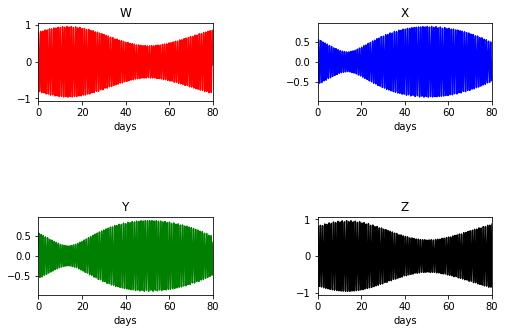

In [3]:
# plot the attitude of the satellite
plots.plot_attitude(gaia, ti=0, tf=80, n_points=1000, style='-')

 ##### 1.1.2 Scanner properties
 We just check some of the properties of the scanner:

In [4]:
print('Size of the field of view of the scanner: ', np.degrees(scanner.zeta_limit),'°')
print('Is the scanner using two telescope in a gaia-like fascion? ', scanner.double_telescope)

Size of the field of view of the scanner:  0.5 °
Is the scanner using two telescope in a gaia-like fascion?  True


# 2. Source detection

In this section we create example stars from real data. The Source object takes as inputs:

> Source('name', $\alpha$, $\delta$, parallax, $\mu_{\alpha}$, $\mu_{\delta}$, $\mu_{r}$)

with units: [string, deg, deg, mas, mas/yr, mas/yr, km/s]



### 2.1 Create source

In [5]:
# Comments / uncomment lines to play with different sources

# source = Source("sirio", 101.28, -16.7161, 379.21, -546.05, -1223.14, -7.6)
source = Source("vega", 279.2333, 38.78, 128.91, 201.03, 286.23, -13.9)
# source = Source("proxima",217.42, -62, 768.7, 3775.40, 769.33, 21.7)

##### 2.1.1 Visualize the evolution of the source in time

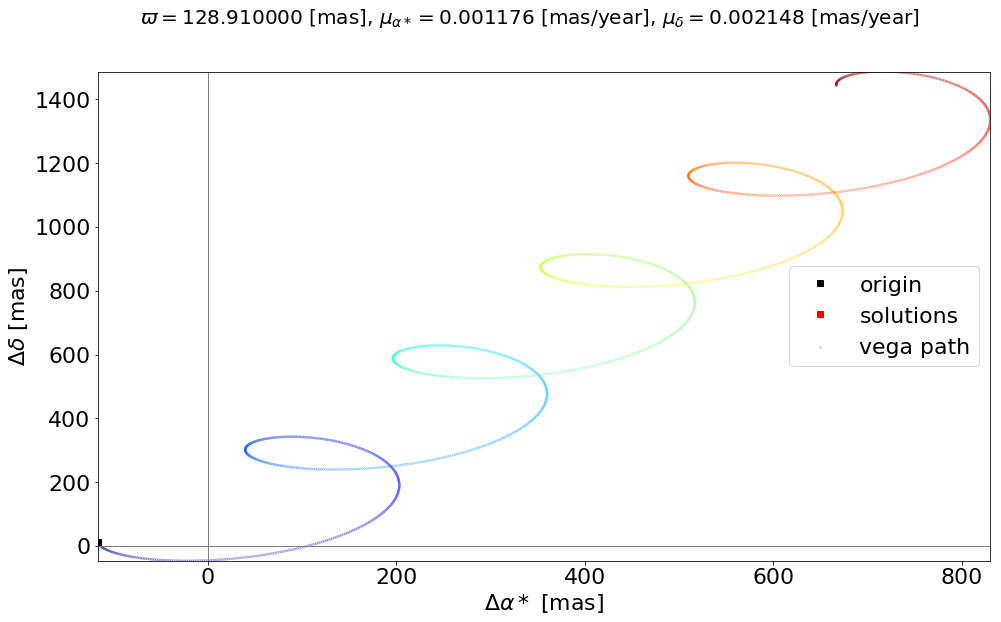

In [6]:
# With respect to equatorial coordinates:
fig = plots.plot_star_trajectory(source, gaia);

### 2.2 Scan source

In [7]:
time_taken_for_scan = scanner.scan(gaia, source, t_init, t_end)
scanner.compute_angles_eta_zeta(gaia, source)  # computes the field angle associated to each observation
print('Scan took: ', time_taken_for_scan, 'seconds')
print('Source observed ', len(scanner.obs_times), 'times')

Scan took:  1.063446044921875 seconds
Source observed  43 times


##### 2.2.1 Visualize scan

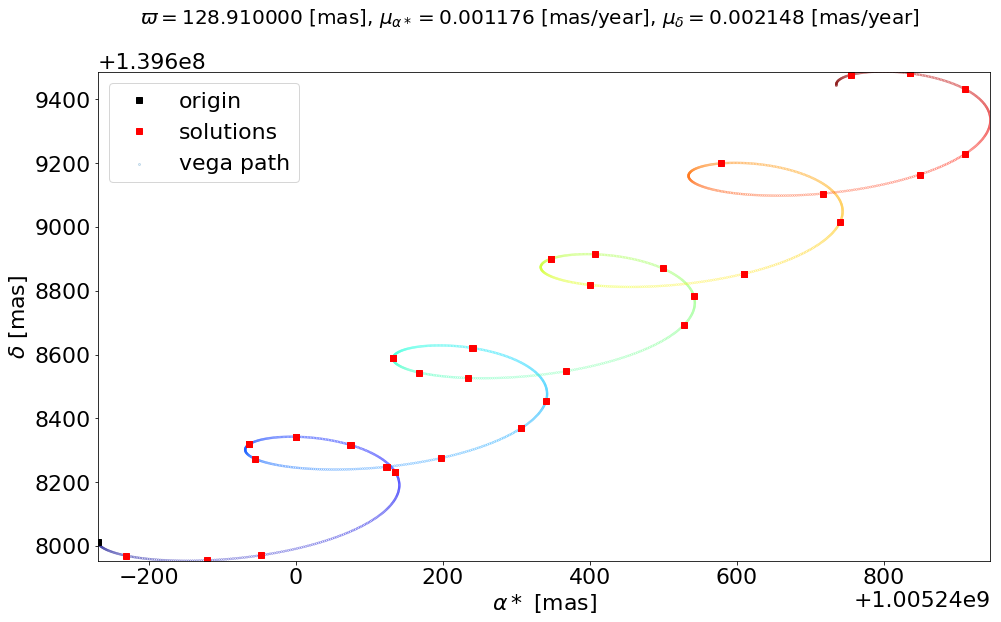

In [11]:
fig = plots.plot_star_trajectory(source, gaia, obs_times=scanner.obs_times, equatorial=True, 
                                 show_scanning_directions=False);

Where the red dots represent the position of the star at the time of observation.

##### 2.2.2 Quantitative results

Check the deviation from 0 in the along scan direction:

In [9]:
print('Scan error in the along scan direction: ', scanner.scanner_error(), '[rads], \nor equivalently,', 
       scanner.scanner_error()/const.rad_per_mas, '[mas]')

Scan error in the along scan direction:  1.9494987634786976e-14 [rads], 
or equivalently, 4.021129847278875e-06 [mas]


Check that all the observations are inside the limitations of the Field of View (FoV) which is [-0.5°, 0.5°]:

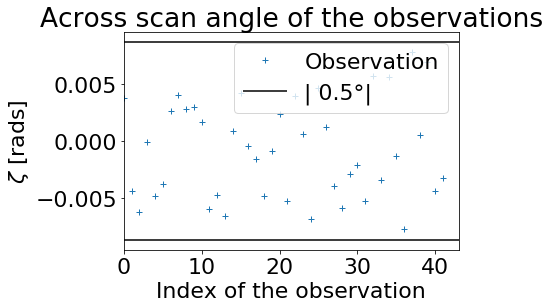

In [10]:
# Check that all the observations are in the field of view:
plt.figure()
plt.title('Across scan angle of the observations')
plt.plot(scanner.zeta_scanned, '+', label='Observation')
plt.hlines(np.radians([-0.5, 0.5]), xmin=0, xmax=len(scanner.obs_times), label='| 0.5°|')
plt.xlim(0, len(scanner.obs_times))
plt.xlabel('Index of the observation')
plt.ylabel('$\zeta$ [rads]')
plt.legend()
plt.show();

Where $\zeta$ is the Across scan angle of the observation.

# 3. Conclusion

Thank you for reading! We hope tha tthis notebook could help you understand the model and we hope you had fun discovering it!  
For more about this project, visit the others notebooks as well as the gaia website.

_For any errors or remarks, don't hesitate to contact us!_